In [1]:
import importlib.util
import os
import sys
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from data_loader import MyDataLoader, SPLIT
from my_config import MyConfig, load_config
import numpy as np
import pandas as pd

In [2]:
def load_module_from_folder(folder_path: str, module_name: str):
    """
    Dynamically load a module from <folder_path>/<module_name>.py
    and return the imported module object.
    """
    module_path = os.path.join(folder_path, f"{module_name}.py")
    if not os.path.isfile(module_path):
        raise FileNotFoundError(f"No such file: {module_path}")

    spec = importlib.util.spec_from_file_location(module_name, module_path)
    module = importlib.util.module_from_spec(spec)
    # make it available in sys.modules in case it imports other local files
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module


# Example usage:
run_folder = Path(r'D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoint\20250601-162547')
model_mod = load_module_from_folder(run_folder, "models")
train_mod = load_module_from_folder(run_folder, "train")


# Load checkpoint

In [3]:
# Find all checkpoint files in the directory following the pattern checkpoint_{epoch}.pt
checkpoint_files = [f for f in os.listdir(run_folder) if f.startswith('checkpoint_') and f.endswith('.pt')]
if checkpoint_files:
    # Sort files by epoch number in descending order and choose the latest checkpoint.
    checkpoint_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]), reverse=True)
    latest_checkpoint_file = checkpoint_files[0]
    print(f"Loading latest checkpoint: {latest_checkpoint_file}")

    train_mod.model.load_state_dict(torch.load(run_folder / latest_checkpoint_file, map_location=train_mod.DEVICE)['model_state_dict'])
else:
    raise FileNotFoundError(f"No checkpoint files found in {run_folder}")

Loading latest checkpoint: checkpoint_10.pt


# Load test data

In [4]:
from _utils import load_scaler_and_transform_df


my_config: MyConfig = load_config(run_folder / 'config.json')

data_loader = MyDataLoader(my_config)
data_loader.load_data()
data_loader.reindex_full_range()
data_loader.lag_features()
data_loader.prepare_df(drop_solar_altitude_below_0=True, drop_nan=True)

method = 'minmax'  # or 'standard', 'maxabs', 'robust', 'normalizer'
scalar_file = run_folder / f'{method}.pkl'
if not os.path.exists(scalar_file):
    raise FileNotFoundError(f"Scalar file {scalar_file} does not exist. Please check the path.")

df_val = load_scaler_and_transform_df(scalar_file, data_loader.get_split(SPLIT.TEST))
X_test, y_test, ts = data_loader.get_X_y(df_val, input_seq_len=60, rolling=True, verbose=True)
test_dataset = train_mod.TimeSeriesDataset(X_test, y_test, device=train_mod.DEVICE)
test_loader = DataLoader(test_dataset, batch_size=train_mod.BATCH_SIZE, shuffle=False)

Before creating sequences: X shape: (513088, 11), y shape: (513088, 1)
After creating sequences: X shape: (469842, 60, 11), y shape: (469842, 60, 1)


# Make predictions

In [5]:
train_mod.model.eval()
preds = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(train_mod.DEVICE), batch_y.to(train_mod.DEVICE)
        predictions = train_mod.model(batch_X)
        preds.append(predictions.cpu().numpy())

y_test = y_test.squeeze()
preds = np.concatenate(preds).squeeze()
display(ts.shape, y_test.shape, preds.shape)

(469842, 60)

(469842, 60)

(469842, 60)

In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1) Suppose scaler was already fitted on X_train (shape=(N, F)), with target in column k.
# 2) At inference, y_pred_scaled has shape = (n_new_samples,)
# Load scaler object
import pickle
def inverse_transform_feature(values:np.ndarray, column_name:str):
    with open(run_folder / f'{method}.pkl', 'rb') as f:
        scaler = pickle.load(f)
    # Find the index of the target column in the scaler
    k = scaler.feature_names_in_.tolist().index(column_name)

    n_new = len(values)
    F = scaler.scale_.shape[0]

    # Build a dummy array of zeros:
    dummy = np.zeros((n_new, F))

    # Put the scaled target into column k:
    dummy[:, k] = values

    # Inverse‐transform the entire dummy array:
    dummy_orig = scaler.inverse_transform(dummy)

    # Now extract just the original‐scale target:
    y_pred_original = dummy_orig[:, k]

    values = y_pred_original.reshape(values.shape)
    return values

y_test = inverse_transform_feature(y_test.reshape(-1), data_loader.get_target_names()[0]).reshape(y_test.shape)
preds = inverse_transform_feature(preds.reshape(-1), data_loader.get_target_names()[0]).reshape(preds.shape)

In [7]:
y_test = pd.DataFrame(y_test, index=ts[:, 0])
preds = pd.DataFrame(preds, index=ts[:, 0])
ts = pd.DataFrame(ts, index=ts[:, 0])
y_test.sort_index(inplace=True)
preds.sort_index(inplace=True)
display(y_test.head(), preds.head(), ts.head())

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2023-01-01 07:43:00,0.069318,0.077426,0.070297,0.070537,0.063348,0.071975,0.087690,0.092312,0.074770,0.077077,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2023-01-01 07:44:00,0.077426,0.070297,0.070537,0.063348,0.071975,0.087690,0.092312,0.074770,0.077077,0.066304,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.004765
2023-01-01 07:45:00,0.070297,0.070537,0.063348,0.071975,0.087690,0.092312,0.074770,0.077077,0.066304,0.069059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.004765,0.000000
2023-01-01 07:46:00,0.070537,0.063348,0.071975,0.087690,0.092312,0.074770,0.077077,0.066304,0.069059,0.066344,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.004765,0.000000,0.000000
2023-01-01 07:47:00,0.063348,0.071975,0.087690,0.092312,0.074770,0.077077,0.066304,0.069059,0.066344,0.071006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.004765,0.000000,0.000000,0.000000


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2023-01-01 07:43:00,221.008406,183.296087,137.529250,94.243932,57.859947,28.787953,6.655485,-9.650230,-21.378975,-30.012034,...,-44.603223,-44.218286,-43.198490,-42.514607,-42.797768,-42.793710,-42.280381,-42.676746,-42.924847,-43.052672
2023-01-01 07:44:00,220.093266,181.275218,136.139823,93.642223,57.206246,28.227107,6.211767,-9.990738,-21.977312,-30.244590,...,-44.218286,-43.198490,-42.514607,-42.797768,-42.793710,-42.280381,-42.676746,-42.924847,-43.052672,-43.466015
2023-01-01 07:45:00,219.627319,181.814029,137.470604,94.635061,57.957875,28.778002,6.593362,-10.065049,-21.826631,-29.644164,...,-43.198490,-42.514607,-42.797768,-42.793710,-42.280381,-42.676746,-42.924847,-43.052672,-43.466015,-43.348455
2023-01-01 07:46:00,221.134829,184.398355,139.688895,96.443276,59.364458,29.797992,6.977807,-9.582065,-20.979029,-28.937396,...,-42.514607,-42.797768,-42.793710,-42.280381,-42.676746,-42.924847,-43.052672,-43.466015,-43.348455,-43.241098
2023-01-01 07:47:00,221.070648,183.469550,138.425488,95.149121,58.197308,28.509880,6.230684,-9.612022,-20.897900,-28.368359,...,-42.797768,-42.793710,-42.280381,-42.676746,-42.924847,-43.052672,-43.466015,-43.348455,-43.241098,-42.974318


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2023-01-01 07:43:00,2023-01-01 07:43:00,2023-01-01 07:44:00,2023-01-01 07:45:00,2023-01-01 07:46:00,2023-01-01 07:47:00,2023-01-01 07:48:00,2023-01-01 07:49:00,2023-01-01 07:50:00,2023-01-01 07:51:00,2023-01-01 07:52:00,...,2023-01-01 08:33:00,2023-01-01 08:34:00,2023-01-01 08:35:00,2023-01-01 08:36:00,2023-01-01 08:37:00,2023-01-01 08:38:00,2023-01-01 08:39:00,2023-01-01 08:40:00,2023-01-01 08:41:00,2023-01-01 08:42:00
2023-01-01 07:44:00,2023-01-01 07:44:00,2023-01-01 07:45:00,2023-01-01 07:46:00,2023-01-01 07:47:00,2023-01-01 07:48:00,2023-01-01 07:49:00,2023-01-01 07:50:00,2023-01-01 07:51:00,2023-01-01 07:52:00,2023-01-01 07:53:00,...,2023-01-01 08:34:00,2023-01-01 08:35:00,2023-01-01 08:36:00,2023-01-01 08:37:00,2023-01-01 08:38:00,2023-01-01 08:39:00,2023-01-01 08:40:00,2023-01-01 08:41:00,2023-01-01 08:42:00,2023-01-01 08:43:00
2023-01-01 07:45:00,2023-01-01 07:45:00,2023-01-01 07:46:00,2023-01-01 07:47:00,2023-01-01 07:48:00,2023-01-01 07:49:00,2023-01-01 07:50:00,2023-01-01 07:51:00,2023-01-01 07:52:00,2023-01-01 07:53:00,2023-01-01 07:54:00,...,2023-01-01 08:35:00,2023-01-01 08:36:00,2023-01-01 08:37:00,2023-01-01 08:38:00,2023-01-01 08:39:00,2023-01-01 08:40:00,2023-01-01 08:41:00,2023-01-01 08:42:00,2023-01-01 08:43:00,2023-01-01 08:44:00
2023-01-01 07:46:00,2023-01-01 07:46:00,2023-01-01 07:47:00,2023-01-01 07:48:00,2023-01-01 07:49:00,2023-01-01 07:50:00,2023-01-01 07:51:00,2023-01-01 07:52:00,2023-01-01 07:53:00,2023-01-01 07:54:00,2023-01-01 07:55:00,...,2023-01-01 08:36:00,2023-01-01 08:37:00,2023-01-01 08:38:00,2023-01-01 08:39:00,2023-01-01 08:40:00,2023-01-01 08:41:00,2023-01-01 08:42:00,2023-01-01 08:43:00,2023-01-01 08:44:00,2023-01-01 08:45:00
2023-01-01 07:47:00,2023-01-01 07:47:00,2023-01-01 07:48:00,2023-01-01 07:49:00,2023-01-01 07:50:00,2023-01-01 07:51:00,2023-01-01 07:52:00,2023-01-01 07:53:00,2023-01-01 07:54:00,2023-01-01 07:55:00,2023-01-01 07:56:00,...,2023-01-01 08:37:00,2023-01-01 08:38:00,2023-01-01 08:39:00,2023-01-01 08:40:00,2023-01-01 08:41:00,2023-01-01 08:42:00,2023-01-01 08:43:00,2023-01-01 08:44:00,2023-01-01 08:45:00,2023-01-01 08:46:00


# Plot predictions

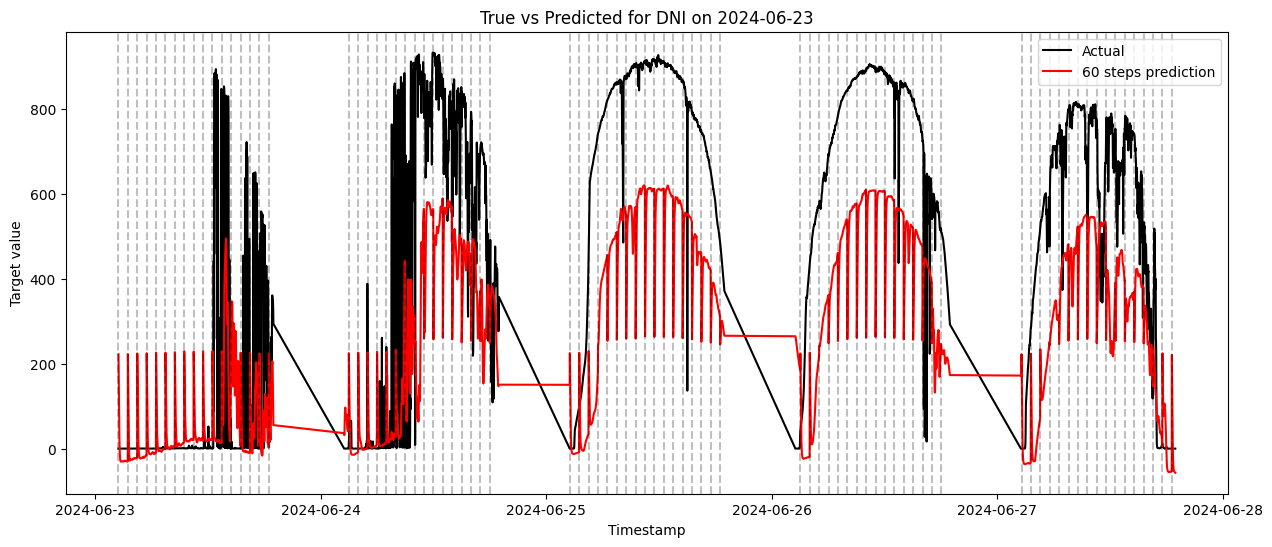

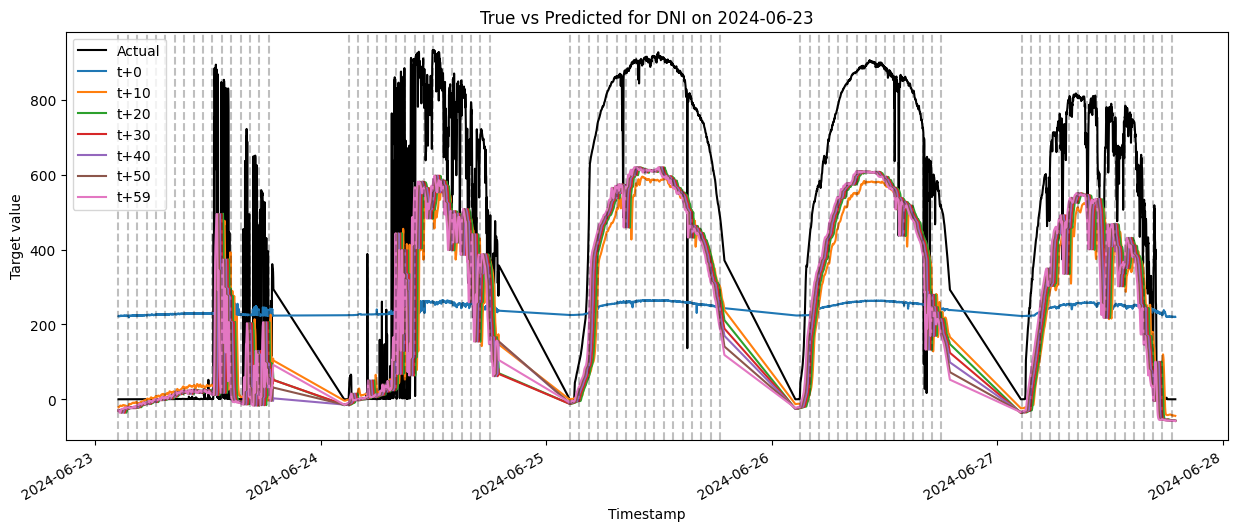

In [8]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(15, 6))
# Select a specific day
day = '2024-06-23'
day_start = pd.to_datetime(day)
day_end = day_start + pd.Timedelta(days=5)
# Filter the timestamps for the selected day
day_mask = (ts.index >= day_start) & (ts.index < day_end)
day_ts = ts[day_mask][0].values

# Plot actual values
ax.plot(day_ts, y_test[day_mask][0].values, label='Actual', color='black')
ax.plot(day_ts, preds[day_mask][::60].values.flatten()[:len(day_ts)], label='60 steps prediction', color='red')
# add vertical lines at every 60th timestep
for i in range(0, len(day_ts), 60):
    ax.axvline(x=day_ts[i], color='black', linestyle='--', alpha=0.25)

ax.set_title(f"True vs Predicted for {my_config.TARGETS[0]} on {day}")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Target value")
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(15, 6))
y_test[day_mask][0].plot(ax=ax, label='Actual', color='black', title=f"True vs Predicted for {my_config.TARGETS[0]} on {day}", xlabel="Timestamp", ylabel="Target value", legend=True)
prediction_steps = list(range(0, 60, 10))
prediction_steps.append(59)
for i in prediction_steps:
    preds[day_mask][::1][i].plot(ax=ax, label=f"t+{i}", legend=True)

for i in range(0, len(day_ts), 60):
    ax.axvline(x=day_ts[i], color='black', linestyle='--', alpha=0.25)

plt.show()

In [9]:
from ForecastEvaluator import ForecastEvaluator


def calculate_errors(y_true, y_pred):
    return ForecastEvaluator(y_true, y_pred).evaluate_all()


error_metrics = {}
for i in range(60):
    error_metrics[f't+{i}'] = calculate_errors(y_test[0], preds[i])

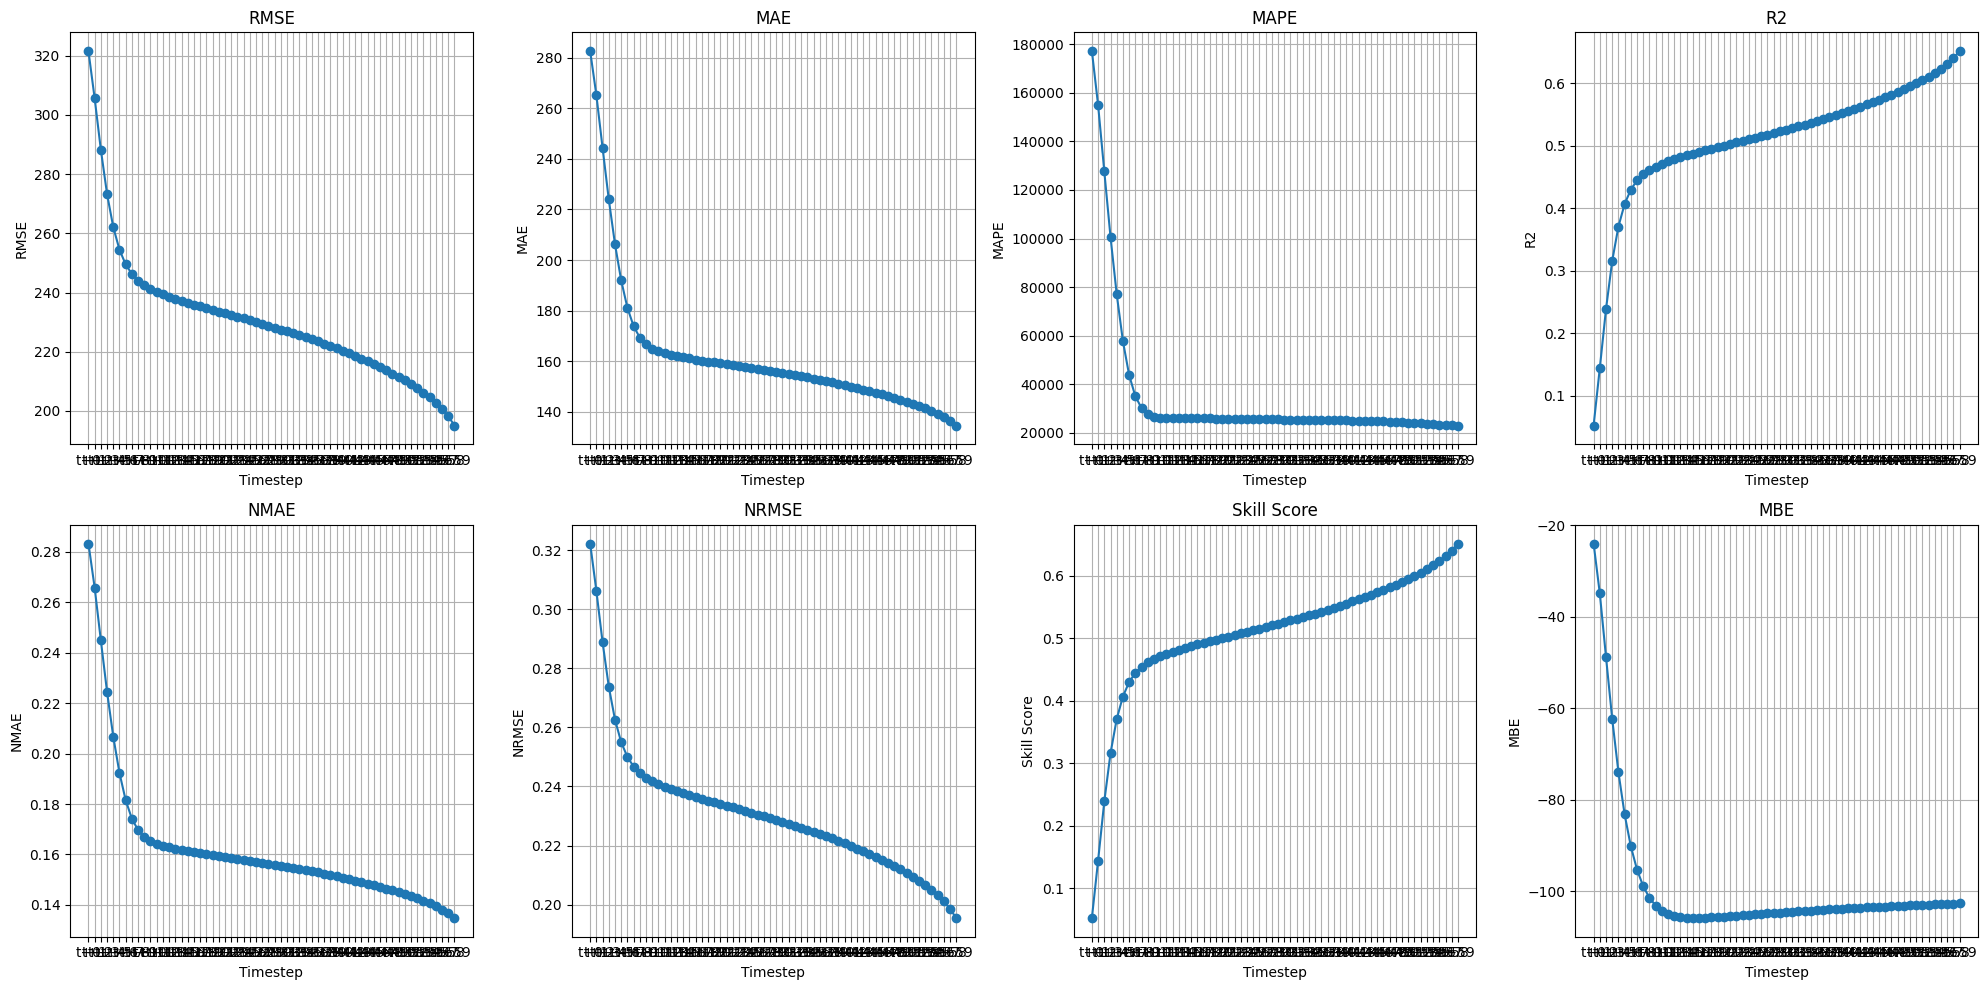

In [10]:
# Extract the timestep keys and error metrics
timesteps = list(error_metrics.keys())
metrics = list(error_metrics['t+56'].keys())

# Prepare figure and axes for subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()

# Plot each metric on a separate subplot
for i, metric in enumerate(metrics):
    values = [error_metrics[ts][metric] for ts in timesteps]
    axs[i].plot(timesteps, values, marker='o')
    axs[i].set_title(metric)
    axs[i].set_xlabel('Timestep')
    axs[i].set_ylabel(metric)
    axs[i].grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [11]:
# y_test.to_pickle(r'LSTM_y_test.pkl')
# preds.to_pickle(r'LSTM_preds.pkl')